In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# from google.colab import files
# src=list(files.upload().values())[0]
# open('utils.py','wb').write(src)
# import utils

In [2]:
# !unzip "drive/MyDrive/심층학습/flower.zip"

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

## 2) Hyperparaeter

In [4]:
batch_size=16
learning_rate=0.0001
epoch=20

n_node=1024
dropratio=0.5

Imgsize=256

In [5]:
Img_dir="./flower/train"
train_data= dset.ImageFolder(Img_dir, transforms.Compose([
    transforms.CenterCrop(Imgsize*2),
    transforms.RandomCrop(Imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(Imgsize),
    transforms.ToTensor()
]))
print(train_data.__len__())

train_batch=data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=2)

28


In [6]:
img_dir="flower/val"
dev_data=dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(size=Imgsize),
    transforms.Resize(Imgsize),
    transforms.ToTensor()
]))
dev_batch=data.DataLoader(dev_data,batch_size=batch_size,shuffle=True,num_workers=2)
img_dir="flower/test"
test_data=dset.ImageFolder(img_dir,transforms.Compose([
    transforms.CenterCrop(size=Imgsize),
    transforms.Resize(Imgsize),
    transforms.ToTensor()
]))
test_batch=data.DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=2)
nclass=len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())
print("Training: %d, Dev: %d, Test:%d" %(train_data.__len__(),dev_data.__len__(),test_data.__len__())),

# of classes: 2
['Gypsophila', 'hydrangea']
{'Gypsophila': 0, 'hydrangea': 1}
28
Training: 28, Dev: 18, Test:28


(None,)

In [7]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['Gypsophila', 'hydrangea']
['Gypsophila', 'hydrangea']
['Gypsophila', 'hydrangea']


In [8]:
vgg=models.vgg19(pretrained=True)
for name,module in vgg.named_children():
    print(name)
print(list(vgg.children())[0])
print(list(vgg.children())[-1])
print(list(vgg.children())[0][0])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU

In [9]:
base_dim=64
fsize=int(Imgsize/32)

class MYVGG(nn.Module):
    def __init__(self):
        super(MYVGG,self).__init__()
        self.layer0=nn.Sequential(*list(vgg.children())[0])
        self.layer1=nn.Sequential(
        nn.Linear(8*base_dim*fsize*fsize,n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),
        
        nn.Linear(n_node,n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),
        
        nn.Linear(n_node,n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),
        
        nn.Linear(n_node,nclass),
        )
        for m in self.layer1.modules():
            if isinstance(m,nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m,nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self,x):
        out=self.layer0(x)
        out=out.view(out.size(0),-1)
        out=self.layer1(out)
        return out

In [10]:
model=MYVGG().cuda()
for params in model.layer0.parameters():
    params.required_grad=False
for params in model.layer1.parameters():
    params.required_grad=True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [11]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [12]:
loss_func=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.layer1.parameters(),lr=learning_rate)

# 5. Train

In [13]:
import utils

total_time=0
disp_step=10

to_train=True
if (to_train==False):
    netname='drive/MyDrive/심층학습/nets/flower_vgg19_10.pkl'
    model=torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()
    train_corr=utils.ComputeCorr(train_batch,model)
    dev_corr = utils.ComputeCorr(dev_batch,model)
    test_corr = utils.ComputeCorr(test_batch,model)
    print("Correct of train: %.2f,dev:%.2f, test: %.2f" 
          %(train_corr,dev_corr,test_corr))
    model.train()
    
    
    netname='drive/MyDrive/심층학습/nets/flower_vgg19_10.pkl'
    
    # graph 그리기
    x_epoch=[]
    y_train_err=[]
    y_dev_err=[]
    y_test_err=[]
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습을 재시작한다면
#     netname='../nets/media_pre_vgg19.pkl'
#     model=torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer().parameters():
#         params.required_grad=False
#     for params in model.layer1.parameters():
#         params.required_grad=True
#     for i in range(34,epoch):
        
    # 재시작하지 않는 다면
    for i in range(epoch):
        start_time=time.time()
        print("%d.." %i),
        for img, label in train_batch:
            img=Variable(img)
            label=Variable(label)
            
            optimizer.zero_grad()
            output = model(img.cuda())
            loss=loss_func(output.cuda(),label.cuda())
            loss.backward()
            optimizer.step()
            
            
        end_time=time.time()
        duration=end_time-start_time
        total_time+=duration
        if (i % disp_step==0) or (i==epoch-1):
            torch.save(model,netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i,epoch,(loss.cpu()).data.numpy()))
            
            
            # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
            model.eval()
            
            # train, dev, train accr
            train_corr=utils.ComputeCorr(train_batch,model)
            dev_corr=utils.ComputeCorr(dev_batch,model)
            test_corr=utils.ComputeCorr(test_batch,model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f"
                  %(train_corr,dev_corr,test_corr)),
            model.train()
            print("time: %.2f sec.." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 50.00,dev:50.00, test: 50.00
0..

[0/20] loss: 0.668, 
Correct of train: 50.00, dev: 50.00, test: 50.00
time: 1.07 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 0.491, 
Correct of train: 78.57, dev: 77.78, test: 71.43
time: 13.09 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.433, 
Correct of train: 92.86, dev: 88.89, test: 85.71
time: 23.94 sec..
Total time: 23.94 sec


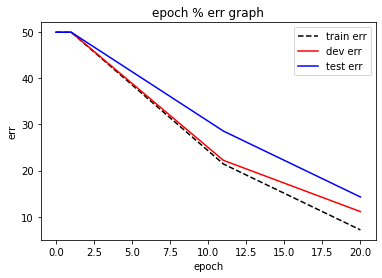

In [14]:
if(to_train):
    plt.plot(x_epoch,y_train_err,color='black',label='train err',linestyle='--')
    plt.plot(x_epoch,y_dev_err,color='red',label='dev err')
    plt.plot(x_epoch,y_test_err,color='blue',label='test err')
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch % err graph')
    plt.legend(loc="upper right")
    plt.show()

Normalized confusion matrix


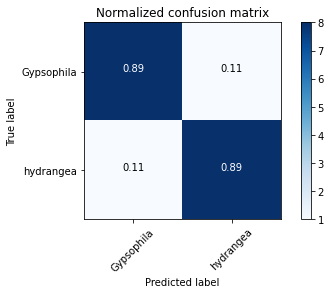

Confusion matrix, without normalization


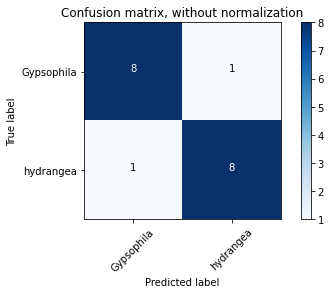

	 acc  |	 pre  |	 rec  |	 f1
 Gypsophila: 0.89 |	 0.89 |	 0.89 |	 0.89
 hydrangea: 0.89 |	 0.89 |	 0.89 |	 0.89
*accuracy: 0.89, precision: 0.89, recall: 0.89, *f1 score: 0.89
[AP]
Gypsophila: 0.90
hydrangea: 0.90

[mAP] 0.900
[miAP] 0.944


(array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1]),
 array([0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]),
 array([0.90764427, 0.95683819, 0.67971438, 0.93479872, 0.81921077,
        0.88505709, 0.9896484 , 0.62657559, 0.85323781, 0.98097128,
        0.78498745, 0.99733496, 0.6381411 , 0.80816436, 0.54660809,
        0.94670194, 0.94906932, 0.73437858]))

In [15]:
model.eval()
utils.EvaluateClassifier(dev_batch,model,dev_data.classes, batch_size)

Normalized confusion matrix


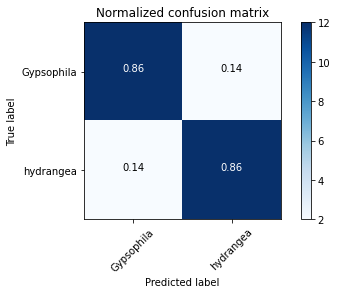

Confusion matrix, without normalization


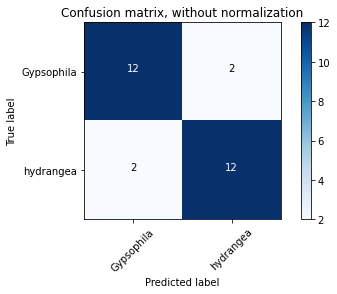

	 acc  |	 pre  |	 rec  |	 f1
 Gypsophila: 0.86 |	 0.86 |	 0.86 |	 0.86
 hydrangea: 0.86 |	 0.86 |	 0.86 |	 0.86
*accuracy: 0.86, precision: 0.86, recall: 0.86, *f1 score: 0.86
[AP]
Gypsophila: 0.95
hydrangea: 0.96

[mAP] 0.954
[miAP] 0.929


In [16]:
model.eval()
_,_,_= utils.EvaluateClassifier(test_batch,model,test_data.classes,batch_size)

Category: Gypsophila
 True predicted images/total Gypsophila category: 8 / 9
Predicted probability:
[0.81921077 0.18078922]


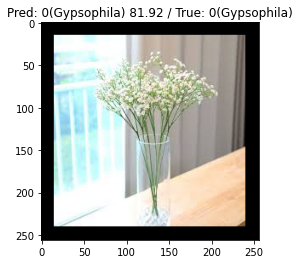

Predicted probability:
[0.6265756 0.3734244]


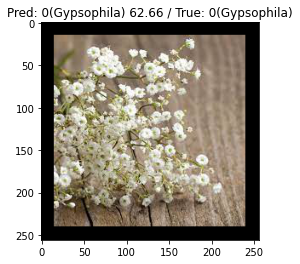

 False predicted images/total Gypsophila category: 1 / 9
Predicted probability:
[0.09235575 0.9076443 ]


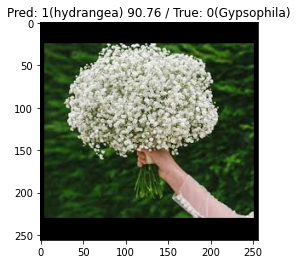

Category: hydrangea
 True predicted images/total hydrangea category: 8 / 9
Predicted probability:
[0.3618589 0.6381411]


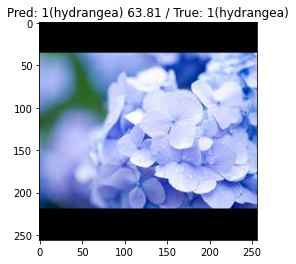

Predicted probability:
[0.01035159 0.9896484 ]


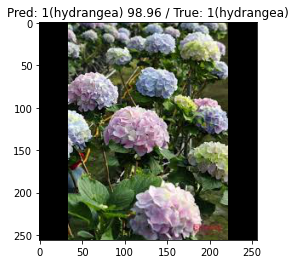

 False predicted images/total hydrangea category: 1 / 9
Predicted probability:
[0.8532378  0.14676222]


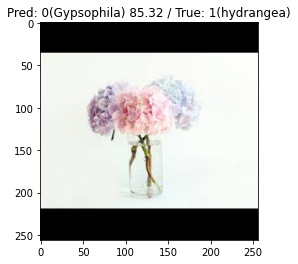

In [17]:
utils.VisTFPred(dev_batch,model,test_data.classes,batch_size,i_n=2)

Category: Gypsophila
 True predicted images/total Gypsophila category: 8 / 9
Predicted probability:
[0.6265756 0.3734244]


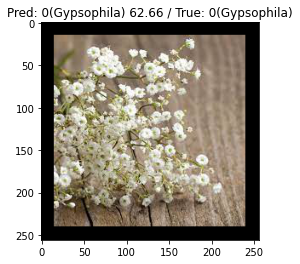

Predicted probability:
[0.6797144  0.32028562]


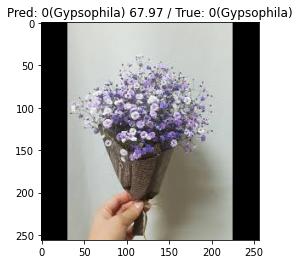

 False predicted images/total Gypsophila category: 1 / 9
Predicted probability:
[0.09235575 0.9076443 ]


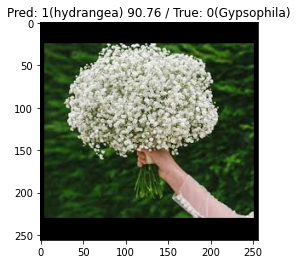

Category: hydrangea
 True predicted images/total hydrangea category: 8 / 9
Predicted probability:
[0.21501254 0.78498745]


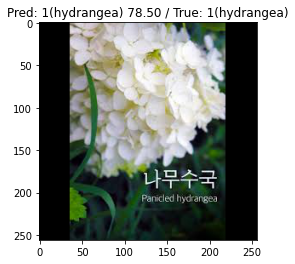

Predicted probability:
[0.26562035 0.73437965]


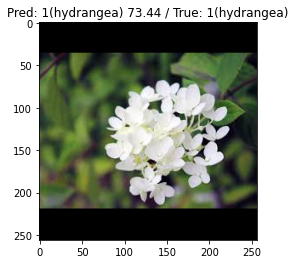

 False predicted images/total hydrangea category: 1 / 9
Predicted probability:
[0.8532378  0.14676222]


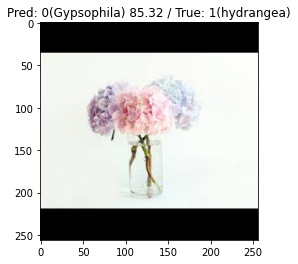

In [18]:
utils.VisTFPred(dev_batch,model,test_data.classes,batch_size,i_n=2)

Category: Gypsophila
 True predicted images/total Gypsophila category: 8 / 9
Predicted probability:
[0.94670194 0.05329804]


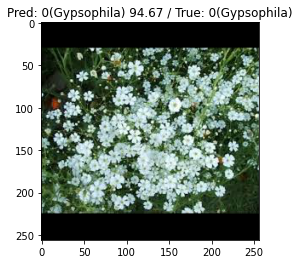

Predicted probability:
[0.8850571  0.11494293]


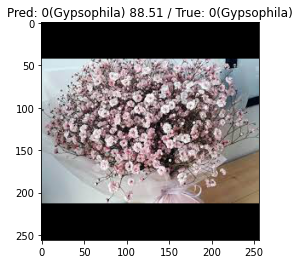

 False predicted images/total Gypsophila category: 1 / 9
Predicted probability:
[0.09235575 0.9076443 ]


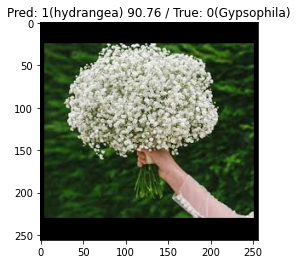

Category: hydrangea
 True predicted images/total hydrangea category: 8 / 9
Predicted probability:
[0.00266504 0.99733496]


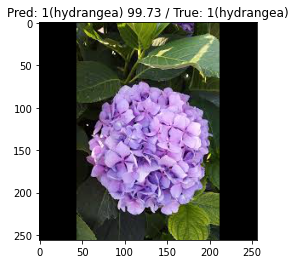

Predicted probability:
[0.01035159 0.9896484 ]


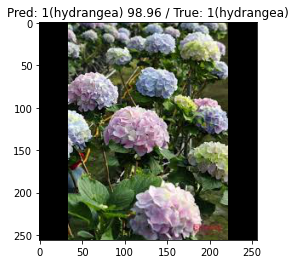

 False predicted images/total hydrangea category: 1 / 9
Predicted probability:
[0.8532378  0.14676222]


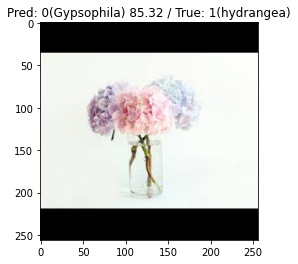

In [19]:
utils.VisTFPred(dev_batch,model,test_data.classes,batch_size,i_n=2)